In [ ]:
# Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing all the packages we are going to use
%%capture
!pip install ftfy regex tqdm matplotlib opencv-python scipy torch scikit-image datasets transformers transformers[torch] accelerate -U
!pip install git+https://github.com/openai/CLIP.git
!pip install tqdm
!pip install timm

import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import filters
from torch import nn

In [ ]:
# Importing the dataset
import datasets
from datasets import load_dataset

train_ds = load_dataset('food101', split="train")
validation_ds = load_dataset('food101', split="validation")

# Spotting the non-RGB images
exclude_idx = []
exclude_idx2 = []
for x in range(len(train_ds)):
  if train_ds[x]["image"].mode != 'RGB':
    exclude_idx.append(x)

for x in range(len(validation_ds)):
  if validation_ds[x]["image"].mode != 'RGB':
    exclude_idx2.append(x)

# create new dataset exluding those idx
train_ds_new = train_ds.select(
    (
        i for i in range(len(train_ds))
        if i not in set(exclude_idx)
    )
)

validation_ds_new = validation_ds.select(
    (
        i for i in range(len(validation_ds))
        if i not in set(exclude_idx2)
    )
)

ds = datasets.DatasetDict({"train":train_ds_new,"validation":validation_ds_new})

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Parameter 'indices'=<generator object <genexpr> at 0x7837d16a5e70> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
# Defining some plotting helper functions for attention map visualization

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

def viz_attn_swinv2(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(8, 8))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

def load_image(img_path, resize=None):
    image = img_path.convert("RGB")
    # image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [ ]:
# More helper functions
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

NameError: ignored

In [ ]:
# Defining the CLIP model
clip_model = "RN50" # ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" # ["layer4", "layer3", "layer2", "layer1"]
blur = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model, preprocess_clip = clip.load(clip_model, device=device, jit=False)

# Prepare text inputs for all classes
import os
from torchvision.datasets import Food101
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

clip_correct_vit_incorrect = []
vit_correct_clip_incorrect = []

In [ ]:
# Importing our trained google/vit-base-patch16-224-in21k model that we stored on our drive
import torch
from tqdm import tqdm

from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor, AutoModel, Swinv2ForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

model_vit = ViTForImageClassification.from_pretrained(f"/content/drive/MyDrive/vit-food-v1-15-epochs").to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(f"/content/drive/MyDrive/vit-food-v1-15-epochs")
model_vit.to(device)

# ViT Predictions
from torchvision.transforms import ToPILImage
import transformers

from transformers import Trainer
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor

import timm
test_dataset = Food101(root=os.path.expanduser("~/.cache"), download=True, split='test') # only to get classes

In [ ]:
# Importing our trained microsoft/swinv2-tiny-patch4-window8-256 model that we stored on our drive
from torchvision import transforms
from PIL import Image
import torch
from transformers import AutoConfig, AutoImageProcessor, AutoModelForImageClassification, Swinv2ForImageClassification

feature_extractor_swinv2 = AutoImageProcessor.from_pretrained("/content/drive/MyDrive/vit-food-swinv2/vit-food-v1/vit-food-swinv2-checkpoint-142050") #/checkpoint-142050
config = AutoConfig.from_pretrained("/content/drive/MyDrive/vit-food-swinv2/vit-food-v1/vit-food-swinv2-checkpoint-142050")
custom_labels = test_dataset.classes
config.num_labels = len(custom_labels)
config.id2label = {str(i): label for i, label in enumerate(custom_labels)}
config.label2id = {label: str(i) for i, label in enumerate(custom_labels)}
model_vit_swinv2 = Swinv2ForImageClassification.from_pretrained("/content/drive/MyDrive/vit-food-swinv2/vit-food-v1/vit-food-swinv2-checkpoint-142050", config=config)
model_vit_swinv2.to(device)

In [ ]:
# Getting the ViT models' predictions for all the images in our test dataset
model_vit_swinv2.to(device)
def get_prediction_probs(model, img, num_classes=len(test_dataset.classes)):
    pixel_values = feature_extractor(img, return_tensors="pt")["pixel_values"].to(device)
    output = model(pixel_values)
    probs, indices = torch.topk(output.logits.softmax(dim=1), k=num_classes)
    id2label = model.config.id2label
    classes = [id2label[idx.item()] for idx in indices[0]]
    probs = probs.squeeze().tolist()
    results = dict(zip(classes, probs))
    return results

def get_prediction_probs_swinv2(model, img, num_classes=len(test_dataset.classes)):
    inputs = feature_extractor_swinv2(images=img, return_tensors="pt").to(device)
    outputs = model_vit_swinv2(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx

vit_predictions = []
vit_predictions_swinv2 = []

for i in tqdm(range(len(test_dataset)), desc="Processing Images"):
    prediction = max(get_prediction_probs(model_vit, ds["validation"][i]["image"]), key=get_prediction_probs(model_vit, ds["validation"][i]["image"]).get)
    prediction_swinv2 = get_prediction_probs_swinv2(model_vit_swinv2, ds["validation"][i]["image"])
    vit_predictions.append(prediction)
    vit_predictions_swinv2.append(prediction_swinv2)

In [ ]:
# Getting the CLIP predictions for all the images in our test dataset
clip_predictions = []

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

text_inputs = torch.cat([clip.tokenize(f"{c}") for c in test_dataset.classes]).to(device)
text_features = clip_model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)

for i in tqdm(range(len(ds['validation'])), desc="Processing Images"):
    with torch.no_grad():
      image_features_clip = clip_model.encode_image(preprocess(ds['validation'][i]['image']).unsqueeze(0).to(device))
      image_features_clip /= image_features_clip.norm(dim=-1, keepdim=True)
      similarity = (image_features_clip @ text_features.T).softmax(dim=-1)
      clip_predictions.append(similarity.argmax(dim=1))


# # Calculate CLIP accuracy
# correct_predictions = 0
# total_images = 0

# for images, labels in test_loader:
#     # The images are already preprocessed and on the right device
#     image_inputs = images.to(device)

#     # Calculate image features
#     with torch.no_grad():
#         image_features = clip_model.encode_image(image_inputs)
#         image_features /= image_features.norm(dim=-1, keepdim=True)
#         # Calculate similarity and predictions
#         similarity = (image_features @ text_features.T).softmax(dim=-1)
#         predicted_indices = similarity.argmax(dim=1)
#         # Update counters
#         correct_predictions += (predicted_indices.cpu() == labels).sum().item()
#         total_images += labels.size(0)

# # Calculate accuracy
# clip_accuracy = 100 * correct_predictions / total_images
# print(f"CLIP Accuracy on Test Set: {clip_accuracy:.2f}%")

In [ ]:
# Comparing Predictions among all models
clip_correct_vit_incorrect = []
vit_correct_clip_incorrect = []
vit_swinv2_correct = []
label_names = test_dataset.classes

for i in tqdm(range(len(test_dataset)), desc="Processing Images"):
    label     = test_dataset.classes[ds['validation'][i]['label']]
    clip_pred = test_dataset.classes[clip_predictions[i]]
    vit_pred  = vit_predictions[i]
    vit_swinv2_pred  = label_names[vit_predictions_swinv2[i]]
    if clip_pred == label and vit_pred != label and vit_swinv2_pred != label:
        clip_correct_vit_incorrect.append((i, ds['validation'][i]['image'], label, clip_pred, vit_pred, vit_swinv2_pred))
    elif vit_pred == label and clip_pred != label and vit_swinv2_pred != label:
        vit_correct_clip_incorrect.append((i, ds['validation'][i]['image'], label, clip_pred, vit_pred, vit_swinv2_pred))
    elif vit_swinv2_pred == label and clip_pred != label and vit_pred != label:
        vit_swinv2_correct.append((i, ds['validation'][i]['image'], label, clip_pred, vit_pred, vit_swinv2_pred))

In [ ]:
print("Clip guesses correctly "+str(len(clip_correct_vit_incorrect))+" images that ViTs missed")
print("ViT guesses correctly "+str(len(vit_correct_clip_incorrect))+" images that CLIP and ViT swinv2 missed")
print("ViT swinv2 guesses correctly "+str(len(vit_swinv2_correct))+" images that CLIP and ViT missed")

<ipython-input-4-36d02cf29474>:14: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))


Image 1: True Label: hamburger, CLIP Prediction: hamburger, ViT Prediction: pulled_pork_sandwich, ViT swinv2 Prediction: beef_tartare
CLIP


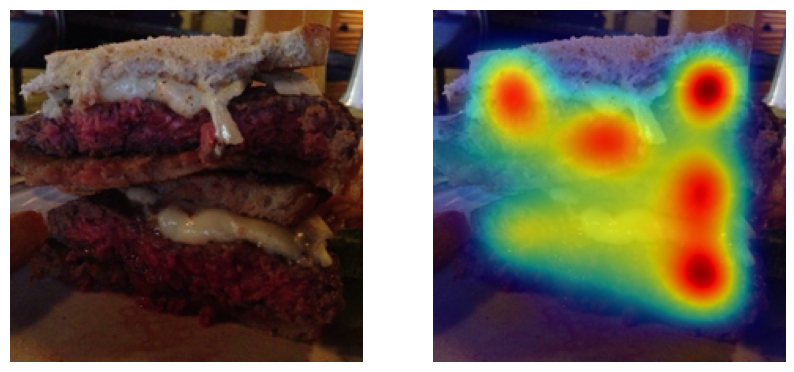

ViT visualizing attention map


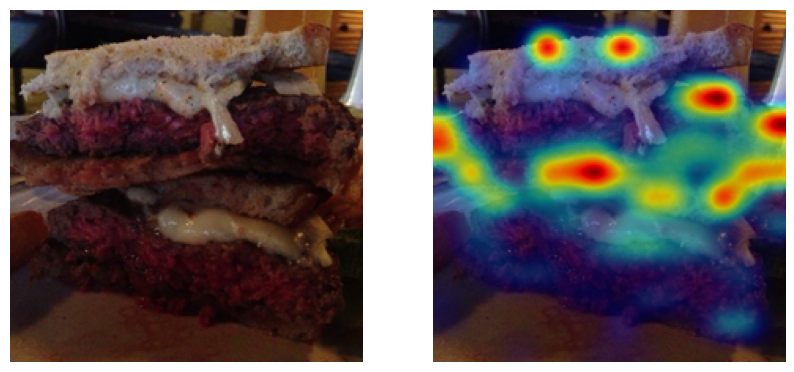

ViT swinv2 visualizing attention map


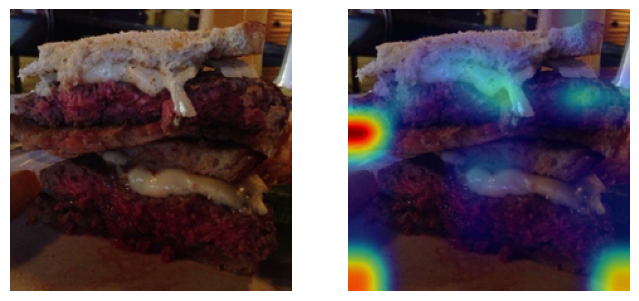

Image 2: True Label: spaghetti_carbonara, CLIP Prediction: spaghetti_carbonara, ViT Prediction: spaghetti_bolognese, ViT swinv2 Prediction: spaghetti_bolognese
CLIP


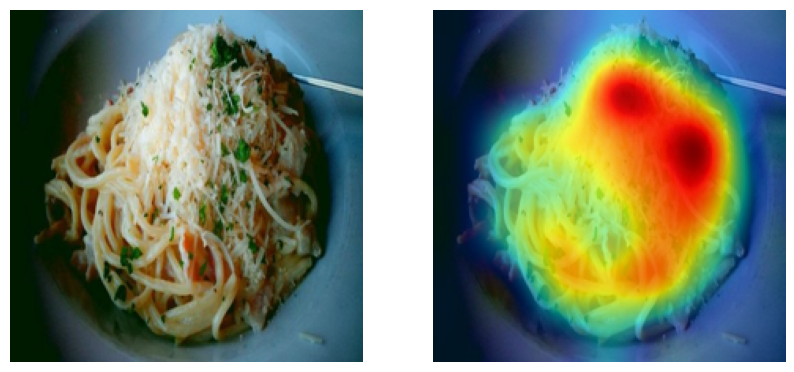

ViT visualizing attention map


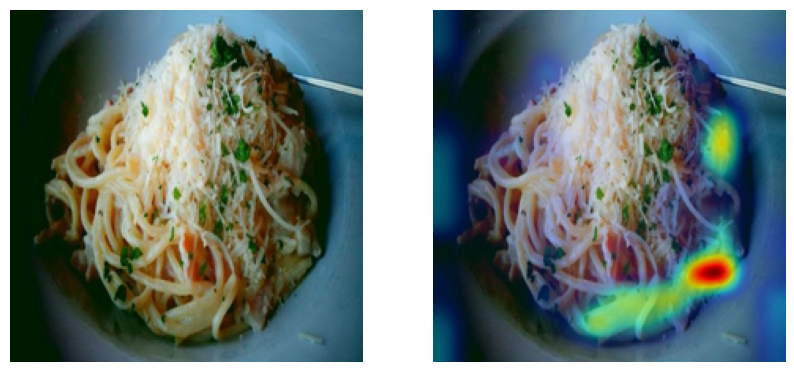

ViT swinv2 visualizing attention map


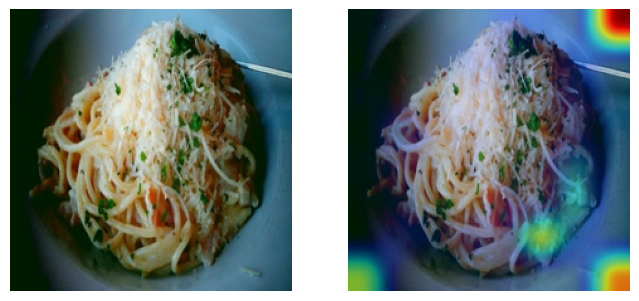

Image 1: True Label: eggs_benedict, CLIP Prediction: crab_cakes, ViT Prediction: eggs_benedict, ViT swinv2 Prediction: shrimp_and_grits
CLIP visualizing attention map


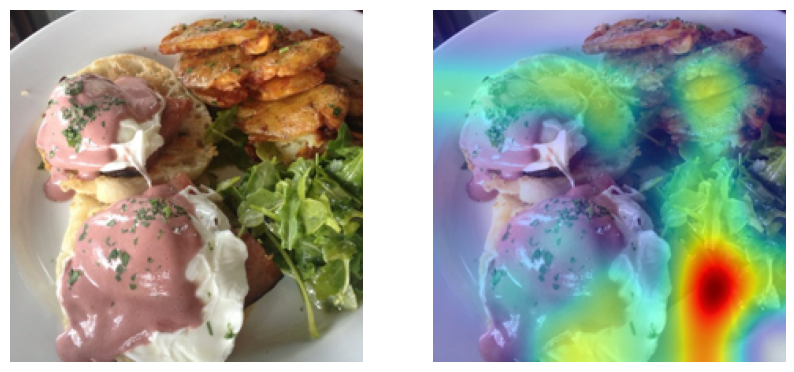

ViT visualizing attention map


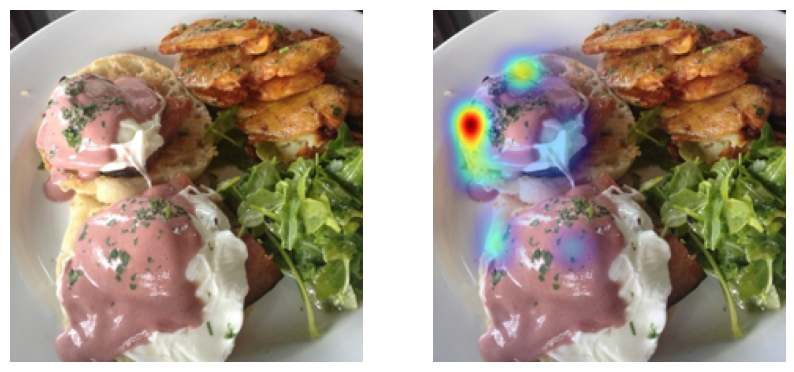

ViT swinv2 visualizing attention map


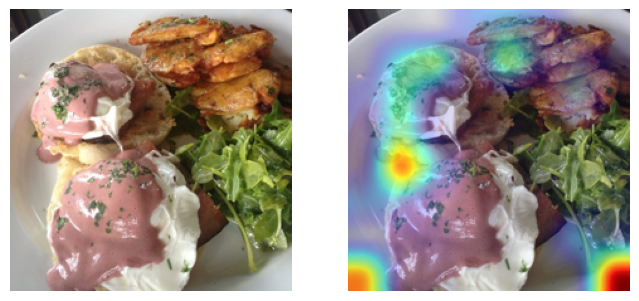

Image 2: True Label: gyoza, CLIP Prediction: spring_rolls, ViT Prediction: gyoza, ViT swinv2 Prediction: spring_rolls
CLIP visualizing attention map


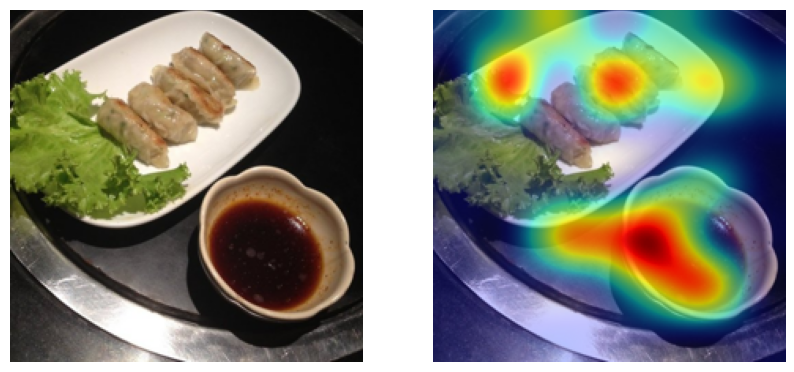

ViT visualizing attention map


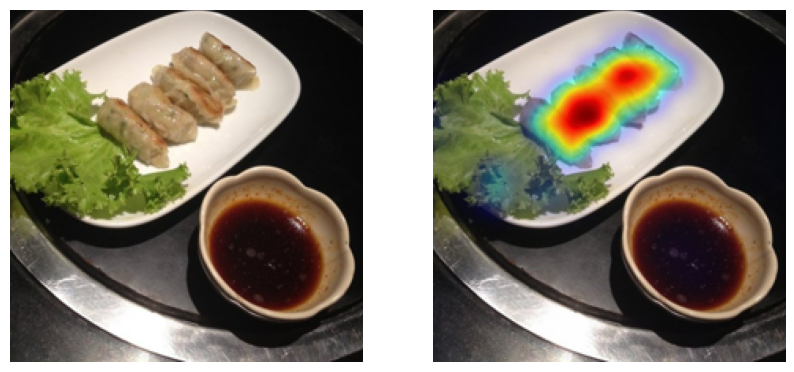

ViT swinv2 visualizing attention map


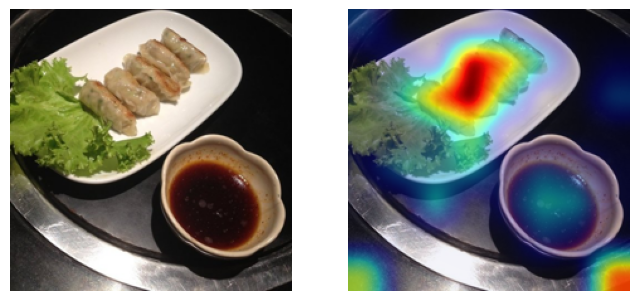

Image 1: True Label: prime_rib, CLIP Prediction: filet_mignon, ViT Prediction: sashimi, ViT swinv2 Prediction: prime_rib
CLIP visualizing attention map


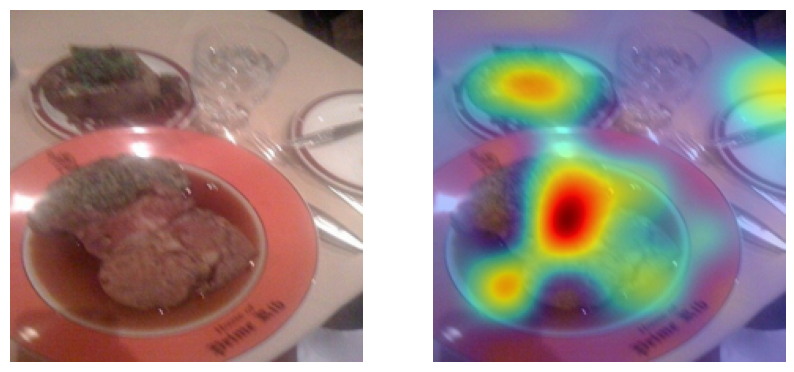

ViT visualizing attention map


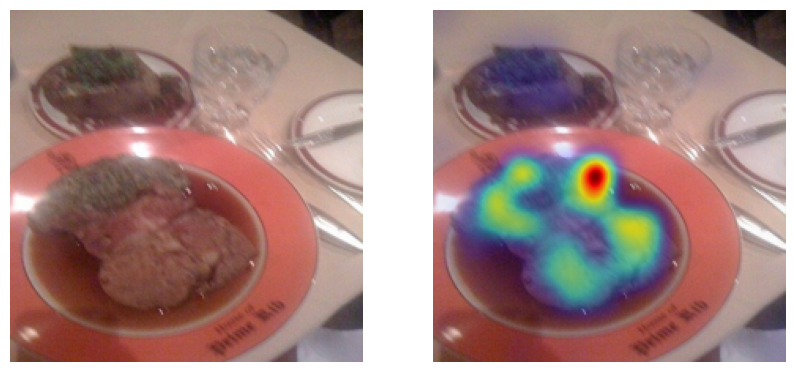

ViT swinv2 visualizing attention map


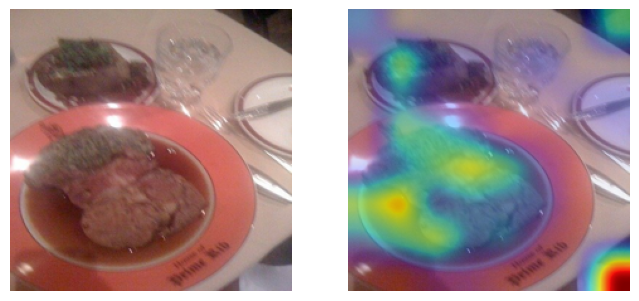

Image 2: True Label: hot_dog, CLIP Prediction: pulled_pork_sandwich, ViT Prediction: pulled_pork_sandwich, ViT swinv2 Prediction: hot_dog
CLIP visualizing attention map


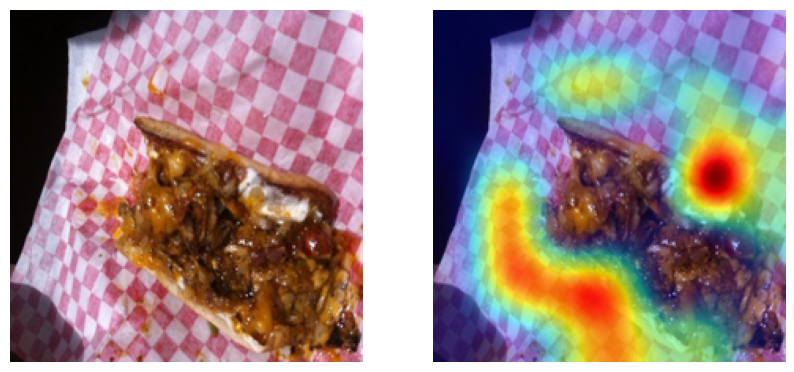

ViT visualizing attention map


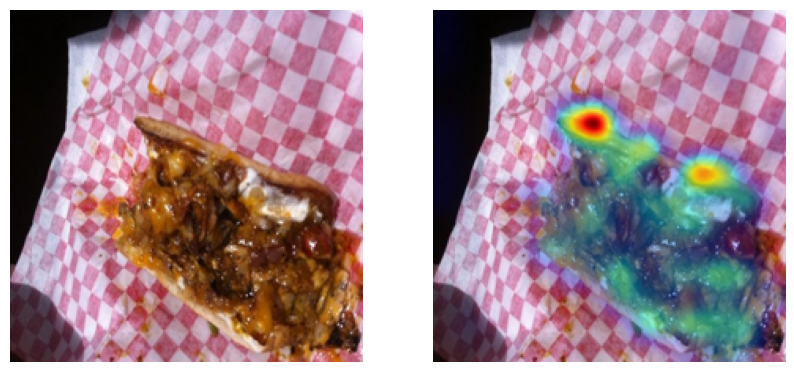

ViT swinv2 visualizing attention map


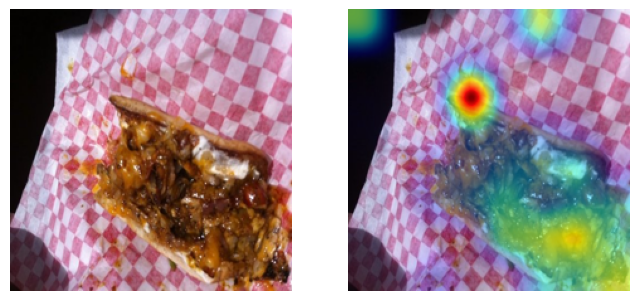

In [ ]:
import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torchvision, torch

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

for i, (idx, img, label, clip_pred, vit_pred, vit_swinv2_pred) in enumerate([clip_correct_vit_incorrect[20], clip_correct_vit_incorrect[500]]):
    true_label_name = label
    clip_label_name = clip_pred
    vit_label_name  = vit_pred
    vit_swinv2_label_name = vit_swinv2_pred

    print(f"Image {i+1}: True Label: {true_label_name}, CLIP Prediction: {clip_label_name}, ViT Prediction: {vit_label_name}, ViT swinv2 Prediction: {vit_swinv2_label_name}")
    print("CLIP")
    image_caption = label

    image_input = preprocess(img).unsqueeze(0).to(device)
    image_path = img
    image_np = load_image(image_path, clip_model.visual.input_resolution)
    text_input = clip.tokenize([image_caption]).to(device)
    attn_map = gradCAM(
        clip_model.visual,
        image_input,
        clip_model.encode_text(text_input).float(),
        getattr(clip_model.visual, saliency_layer)
    )
    attn_map = attn_map.squeeze().detach().cpu().numpy()
    viz_attn(image_np, attn_map, blur)

    print("ViT visualizing attention map")
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    outputs = model_vit(pixel_values, output_attentions=True, interpolate_pos_encoding=True)

    attentions = outputs.attentions[-1]

    attention_weights = attentions[0]
    attention_weights = attention_weights.mean(dim=0)
    attention_map = attention_weights[0, 1:]
    attention_map = attention_map.reshape(14, 14)
    attention_map = attention_map.unsqueeze(0).unsqueeze(0)
    attention_map = F.interpolate(attention_map, size=(224, 224), mode='bilinear')
    attention_map = attention_map - attention_map.min()
    attention_map = attention_map / attention_map.max()
    attention_map = attention_map.squeeze().detach().cpu().numpy()
    viz_attn(image_np, attention_map, blur)

    # # --- If you want to plot the 12 attention heads separately ---
    # print("ViT visualizing attention map")
    # pixel_values = feature_extractor(images=image_data, return_tensors="pt").pixel_values
    # pixel_values = pixel_values.to(device)
    # outputs = model_vit(pixel_values, output_attentions=True, interpolate_pos_encoding=True)

    # attentions = outputs.attentions[-1] # we are only interested in the attention maps of the last layer
    # nh = attentions.shape[1] # number of head

    # # we keep only the output patch attention
    # attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    # threshold = 0.6
    # w_featmap = pixel_values.shape[-2] // model_vit.config.patch_size
    # h_featmap = pixel_values.shape[-1] // model_vit.config.patch_size

    # # we keep only a certain percentage of the mass
    # val, idx = torch.sort(attentions)
    # val /= torch.sum(val, dim=1, keepdim=True)
    # cumval = torch.cumsum(val, dim=1)
    # th_attn = cumval > (1 - threshold)
    # idx2 = torch.argsort(idx)
    # for head in range(nh):
    #     th_attn[head] = th_attn[head][idx2[head]]
    # th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # # interpolate
    # th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=model_vit.config.patch_size, mode="nearest")[0].cpu().numpy()

    # attentions = attentions.reshape(nh, w_featmap, h_featmap)
    # attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=model_vit.config.patch_size, mode="nearest")[0].cpu()
    # attentions = attentions.detach().numpy()

    # # show and save attentions heatmaps
    # output_dir = '.'
    # os.makedirs(output_dir, exist_ok=True)
    # torchvision.utils.save_image(torchvision.utils.make_grid(pixel_values, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
    # for j in range(nh):
    #     fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
    #     plt.figure()
    #     plt.imshow(attentions[j])
    #     plt.imsave(fname=fname, arr=attentions[j], format='png')
    # ---------------------------------------------------------------------------

    print("ViT swinv2 visualizing attention map")
    pixel_values = feature_extractor_swinv2(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    outputs = model_vit_swinv2(pixel_values, output_attentions=True)

    attentions = outputs.attentions[-1]

    attention_weights = attentions[0]
    attention_weights = attention_weights.mean(dim=0)
    attention_map = attention_weights[0, 1:]
    attention_map = attention_map.reshape(7, 9)
    attention_map = attention_map.unsqueeze(0).unsqueeze(0)
    attention_map = F.interpolate(attention_map, size=(224, 224), mode='bilinear')
    attention_map = attention_map - attention_map.min()
    attention_map = attention_map / attention_map.max()
    attention_map = attention_map.squeeze().detach().cpu().numpy()
    viz_attn_swinv2(image_np, attention_map, blur)

for i, (idx, img, label, clip_pred, vit_pred, vit_swinv2_pred) in enumerate([vit_correct_clip_incorrect[100], vit_correct_clip_incorrect[500]]):
    true_label_name = label
    clip_label_name = clip_pred
    vit_label_name  = vit_pred
    vit_swinv2_label_name = vit_swinv2_pred

    print(f"Image {i+1}: True Label: {true_label_name}, CLIP Prediction: {clip_label_name}, ViT Prediction: {vit_label_name}, ViT swinv2 Prediction: {vit_swinv2_label_name}")
    print("CLIP visualizing attention map")
    first_element = train_ds[0]
    image_caption = label

    image_input = preprocess(img).unsqueeze(0).to(device)
    image_path = img
    image_np = load_image(image_path, clip_model.visual.input_resolution)
    text_input = clip.tokenize([image_caption]).to(device)
    attn_map = gradCAM(
        clip_model.visual,
        image_input,
        clip_model.encode_text(text_input).float(),
        getattr(clip_model.visual, saliency_layer)
    )
    attn_map = attn_map.squeeze().detach().cpu().numpy()
    viz_attn(image_np, attn_map, blur)

    print("ViT visualizing attention map")
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    outputs = model_vit(pixel_values, output_attentions=True, interpolate_pos_encoding=True)

    attentions = outputs.attentions[-1]
    nh = attentions.shape[1]
    attention_weights = attentions[0]
    attention_weights = attention_weights.mean(dim=0)
    attention_map = attention_weights[0, 1:]
    attention_map = attention_map.reshape(14, 14)
    attention_map = attention_map.unsqueeze(0).unsqueeze(0)
    attention_map = F.interpolate(attention_map, size=(224, 224), mode='bilinear')
    attention_map = attention_map - attention_map.min()
    attention_map = attention_map / attention_map.max()
    attention_map = attention_map.squeeze().detach().cpu().numpy()
    viz_attn(image_np, attention_map, blur)

    print("ViT swinv2 visualizing attention map")
    pixel_values = feature_extractor_swinv2(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    outputs = model_vit_swinv2(pixel_values, output_attentions=True)

    attentions = outputs.attentions[-1]

    attention_weights = attentions[0]
    attention_weights = attention_weights.mean(dim=0)
    attention_map = attention_weights[0, 1:]
    attention_map = attention_map.reshape(7,9)
    attention_map = attention_map.unsqueeze(0).unsqueeze(0)
    attention_map = F.interpolate(attention_map, size=(224, 224), mode='bilinear')
    attention_map = attention_map - attention_map.min()
    attention_map = attention_map / attention_map.max()
    attention_map = attention_map.squeeze().detach().cpu().numpy()
    viz_attn_swinv2(image_np, attention_map, blur)

for i, (idx, img, label, clip_pred, vit_pred, vit_swinv2_pred) in enumerate([vit_swinv2_correct[4], vit_swinv2_correct[350]]):
    true_label_name = label
    clip_label_name = clip_pred
    vit_label_name  = vit_pred
    vit_swinv2_label_name = vit_swinv2_pred

    print(f"Image {i+1}: True Label: {true_label_name}, CLIP Prediction: {clip_label_name}, ViT Prediction: {vit_label_name}, ViT swinv2 Prediction: {vit_swinv2_label_name}")
    print("CLIP visualizing attention map")
    first_element = train_ds[0]
    image_caption = label

    image_input = preprocess(img).unsqueeze(0).to(device)
    image_path = img
    image_np = load_image(image_path, clip_model.visual.input_resolution)
    text_input = clip.tokenize([image_caption]).to(device)
    attn_map = gradCAM(
        clip_model.visual,
        image_input,
        clip_model.encode_text(text_input).float(),
        getattr(clip_model.visual, saliency_layer)
    )
    attn_map = attn_map.squeeze().detach().cpu().numpy()
    viz_attn(image_np, attn_map, blur)

    print("ViT visualizing attention map")
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    outputs = model_vit(pixel_values, output_attentions=True, interpolate_pos_encoding=True)

    attentions = outputs.attentions[-1]
    nh = attentions.shape[1]
    attention_weights = attentions[0]
    attention_weights = attention_weights.mean(dim=0)
    attention_map = attention_weights[0, 1:]
    attention_map = attention_map.reshape(14, 14)
    attention_map = attention_map.unsqueeze(0).unsqueeze(0)
    attention_map = F.interpolate(attention_map, size=(224, 224), mode='bilinear')
    attention_map = attention_map - attention_map.min()
    attention_map = attention_map / attention_map.max()
    attention_map = attention_map.squeeze().detach().cpu().numpy()
    viz_attn(image_np, attention_map, blur)

    print("ViT swinv2 visualizing attention map")
    pixel_values = feature_extractor_swinv2(images=img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    outputs = model_vit_swinv2(pixel_values, output_attentions=True)

    attentions = outputs.attentions[-1]

    attention_weights = attentions[0]
    attention_weights = attention_weights.mean(dim=0)
    attention_map = attention_weights[0, 1:]
    attention_map = attention_map.reshape(7,9)
    attention_map = attention_map.unsqueeze(0).unsqueeze(0)
    attention_map = F.interpolate(attention_map, size=(224, 224), mode='bilinear')
    attention_map = attention_map - attention_map.min()
    attention_map = attention_map / attention_map.max()
    attention_map = attention_map.squeeze().detach().cpu().numpy()
    viz_attn_swinv2(image_np, attention_map, blur)
